In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from insilico_mpra.config import TrainingConfig
from insilico_mpra.models.lightning_module import LitModel
from insilico_mpra.data.utils import create_test_dataloader

/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [ ]:
# def predict_from_hdf5(model, config, data_file, split='test', batch_size=1024, num_workers=4):
#     """Make predictions on HDF5 dataset."""
#     # Create test dataloader
#     test_dl = create_test_dataloader(config, data_file, split=split)

#     # Setup trainer for prediction
#     trainer = pl.Trainer(
#         accelerator='gpu' if torch.cuda.is_available() else 'cpu',
#         devices=[config.device] if torch.cuda.is_available() else 1,
#         precision='16-mixed' if torch.cuda.is_available() else 32,
#         logger=False,
#         enable_checkpointing=False,
#         enable_progress_bar=True
#     )

#     # Get predictions
#     predictions = trainer.predict(model, test_dl)
#     y_pred = torch.cat(predictions).cpu().numpy()

#     # Get true values for comparison
#     dataset = test_dl.dataset
#     y_true = dataset.targets

#     return y_pred, y_true


In [3]:
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive evaluation metrics."""
    metrics = {}

    # Correlation metrics
    pearson_corr, pearson_p = pearsonr(y_true, y_pred)
    spearman_corr, spearman_p = spearmanr(y_true, y_pred)

    metrics['pearson_correlation'] = pearson_corr
    metrics['pearson_p_value'] = pearson_p
    metrics['spearman_correlation'] = spearman_corr
    metrics['spearman_p_value'] = spearman_p

    # Regression metrics
    metrics['mse'] = mean_squared_error(y_true, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2_score'] = r2_score(y_true, y_pred)

    # Additional metrics
    metrics['mean_true'] = np.mean(y_true)
    metrics['mean_pred'] = np.mean(y_pred)
    metrics['std_true'] = np.std(y_true)
    metrics['std_pred'] = np.std(y_pred)

    # Residual analysis
    residuals = y_pred - y_true
    metrics['mean_residual'] = np.mean(residuals)
    metrics['std_residual'] = np.std(residuals)

    return metrics

In [4]:
def plot_evaluation_results(y_true, y_pred, metrics, output_dir, save_plots=True):
    """Create comprehensive evaluation plots."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Scatter plot of predictions vs true values
    axes[0, 0].scatter(y_true, y_pred, alpha=0.6, s=20)
    axes[0, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('True Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title(f'Predictions vs True Values\nPearson r = {metrics["pearson_correlation"]:.3f}')
    axes[0, 0].grid(True, alpha=0.3)

    # Residual plot
    residuals = y_pred - y_true
    axes[0, 1].scatter(y_true, residuals, alpha=0.6, s=20)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('True Values')
    axes[0, 1].set_ylabel('Residuals (Pred - True)')
    axes[0, 1].set_title(f'Residual Plot\nMean = {metrics["mean_residual"]:.3f}')
    axes[0, 1].grid(True, alpha=0.3)

    # Distribution of true vs predicted values
    axes[1, 0].hist(y_true, bins=50, alpha=0.7, label='True', density=True)
    axes[1, 0].hist(y_pred, bins=50, alpha=0.7, label='Predicted', density=True)
    axes[1, 0].set_xlabel('Values')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Residual histogram
    axes[1, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'Residual Distribution\nStd = {metrics["std_residual"]:.3f}')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plots:
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True, parents=True)
        plt.savefig(output_dir / 'evaluation_plots.png', dpi=300, bbox_inches='tight')
        print(f"Evaluation plots saved to {output_dir / 'evaluation_plots.png'}")

    plt.show()

In [5]:
def create_evaluation_report(metrics, model_info, output_dir):
    """Create comprehensive evaluation report."""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    report_path = output_dir / 'evaluation_report.txt'

    with open(report_path, 'w') as f:
        f.write("MPRA LegNet Model Evaluation Report\n")
        f.write("=" * 50 + "\n\n")

        f.write("Model Information:\n")
        f.write(f"  Configuration: {model_info.get('config_path', 'N/A')}\n")
        f.write(f"  Checkpoint: {model_info.get('checkpoint_path', 'N/A')}\n")
        f.write(f"  Data: {model_info.get('data_path', 'N/A')}\n")
        f.write(f"  Split: {model_info.get('split', 'N/A')}\n")
        f.write(f"  Samples: {model_info.get('n_samples', 'N/A')}\n\n")

        f.write("Performance Metrics:\n")
        f.write(f"  Pearson Correlation:  {metrics['pearson_correlation']:.4f} (p={metrics['pearson_p_value']:.2e})\n")
        f.write(f"  Spearman Correlation: {metrics['spearman_correlation']:.4f} (p={metrics['spearman_p_value']:.2e})\n")
        f.write(f"  R² Score:             {metrics['r2_score']:.4f}\n")
        f.write(f"  RMSE:                 {metrics['rmse']:.4f}\n")
        f.write(f"  MAE:                  {metrics['mae']:.4f}\n")
        f.write(f"  MSE:                  {metrics['mse']:.4f}\n\n")

        f.write("Data Statistics:\n")
        f.write(f"  True Values:      Mean={metrics['mean_true']:.4f}, Std={metrics['std_true']:.4f}\n")
        f.write(f"  Predicted Values: Mean={metrics['mean_pred']:.4f}, Std={metrics['std_pred']:.4f}\n")
        f.write(f"  Residuals:        Mean={metrics['mean_residual']:.4f}, Std={metrics['std_residual']:.4f}\n")

    print(f"Evaluation report saved to {report_path}")

In [6]:
from mpralegnet.predict import (
    load_model,
    load_data_from_hdf5,
    predict_from_onehot,
    predict_with_reverse_complement
)


def run(
    checkpoint,
    config,
    data,
    split='test',
    batch_size=1024,
    num_workers=4,
    output_dir=Path('./results'),
    reverse_complement=False,
):
    # Load model
    print(f"Loading model from {checkpoint}")
    model, config = load_model(config, checkpoint)

    # Make predictions
    print(f"Making predictions on {split} split...")
    sequences, targets = load_data_from_hdf5(data, split=split)
    if reverse_complement:
        print("Using test-time augmentation with reverse complement...")
        predictions = predict_with_reverse_complement(
            model, sequences, batch_size, num_workers)
    else:
        print("Making predictions without augmentation...")
        predictions = predict_from_onehot(
            model, sequences, batch_size, num_workers)
    print(f"Generated predictions for {len(predictions)} samples")

    # Calculate metrics
    print("Calculating evaluation metrics...")
    metrics = calculate_metrics(targets, predictions)

   # Create plots
    print("Creating evaluation plots...")
    plot_evaluation_results(targets, predictions, metrics, output_dir, save_plots=True)

    # Create evaluation report
    model_info = {
        'config_path': config,
        'checkpoint_path': checkpoint,
        'data_path': data,
        'split': split,
        'n_samples': len(predictions)
    }
    create_evaluation_report(metrics, model_info, output_dir)

    # Save predictions
    results_df = pd.DataFrame({
        'targets': targets,
        'predictions': predictions,
        'residuals': predictions - targets
    })
    results_df.to_csv(output_dir / 'predictions.csv', index=False)
    print(f"Predictions saved to {output_dir / 'predictions.csv'}")

    print(f"\nEvaluation completed! Results saved to {output_dir}")

##### Evaluating checkpoint 0 #####
Loading model from model_weight/0/best_model-epoch=28-val_pearson=0.814.ckpt
Making predictions on test split...
Using test-time augmentation with reverse complement...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/0/evaluation_plots.png


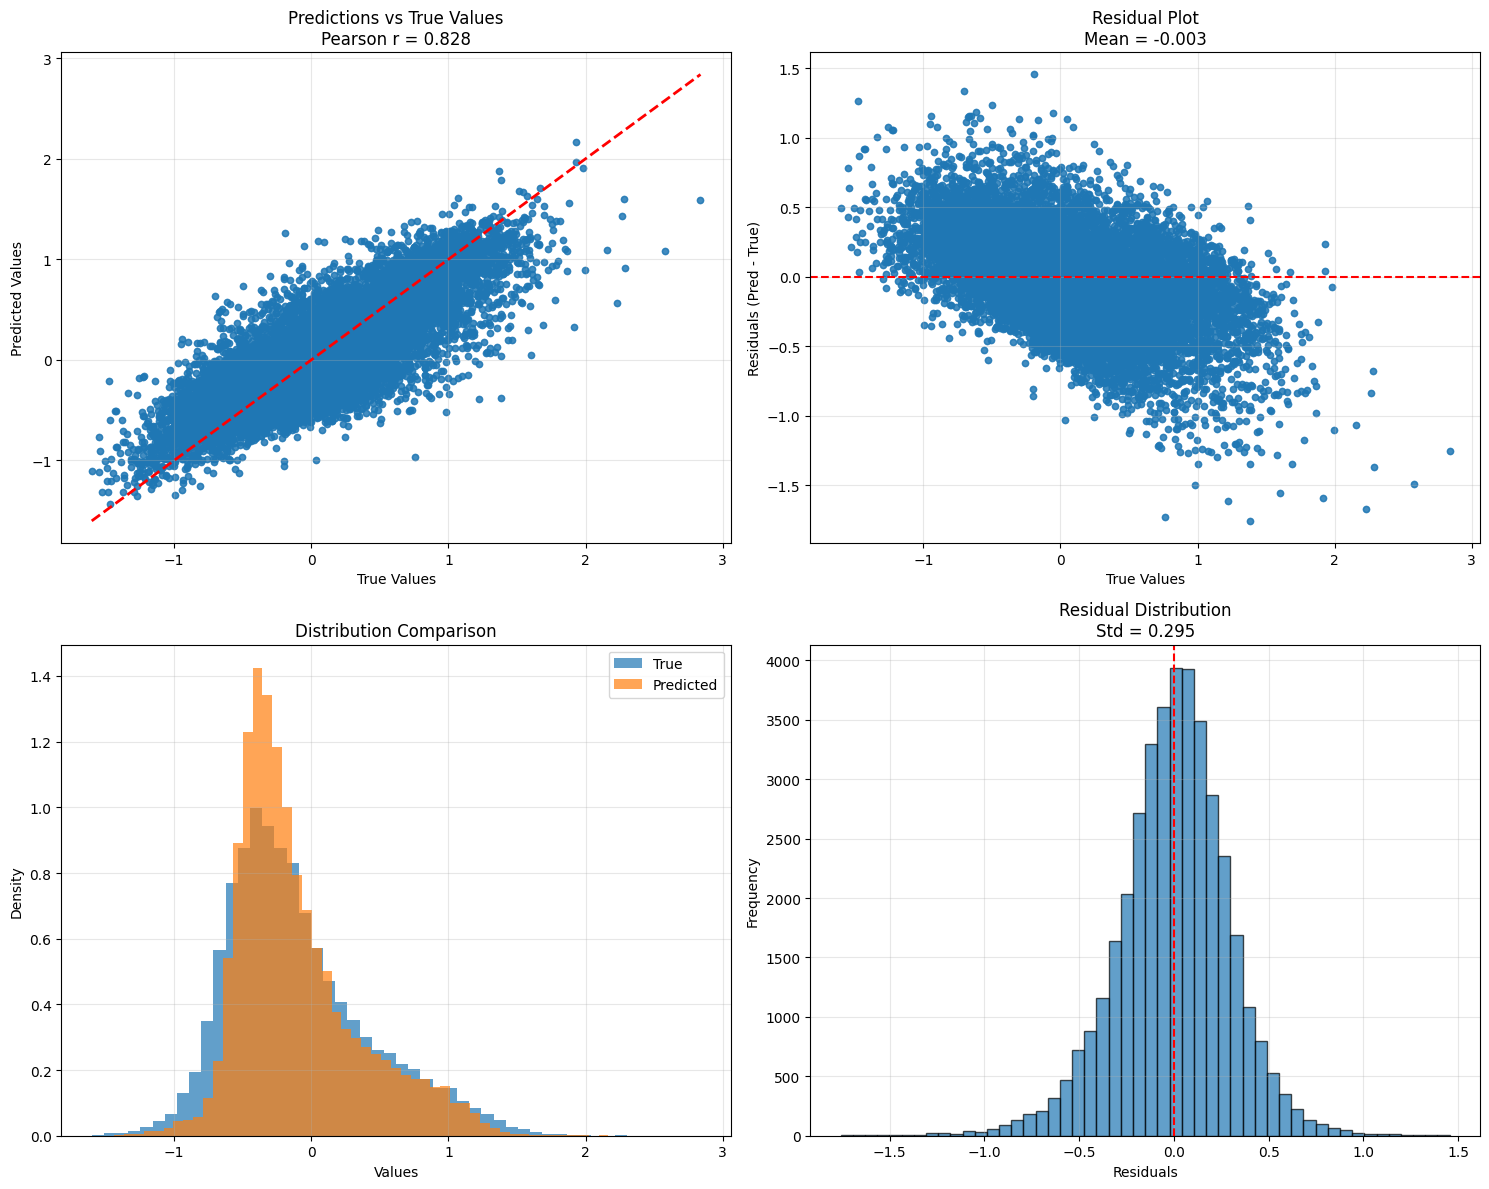

Evaluation report saved to results_rc/0/evaluation_report.txt
Predictions saved to results_rc/0/predictions.csv

Evaluation completed! Results saved to results_rc/0
##### Evaluating checkpoint 1 #####
Loading model from model_weight/1/best_model-epoch=28-val_pearson=0.814.ckpt
Making predictions on test split...
Using test-time augmentation with reverse complement...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:12<00:00,  3.05it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/1/evaluation_plots.png


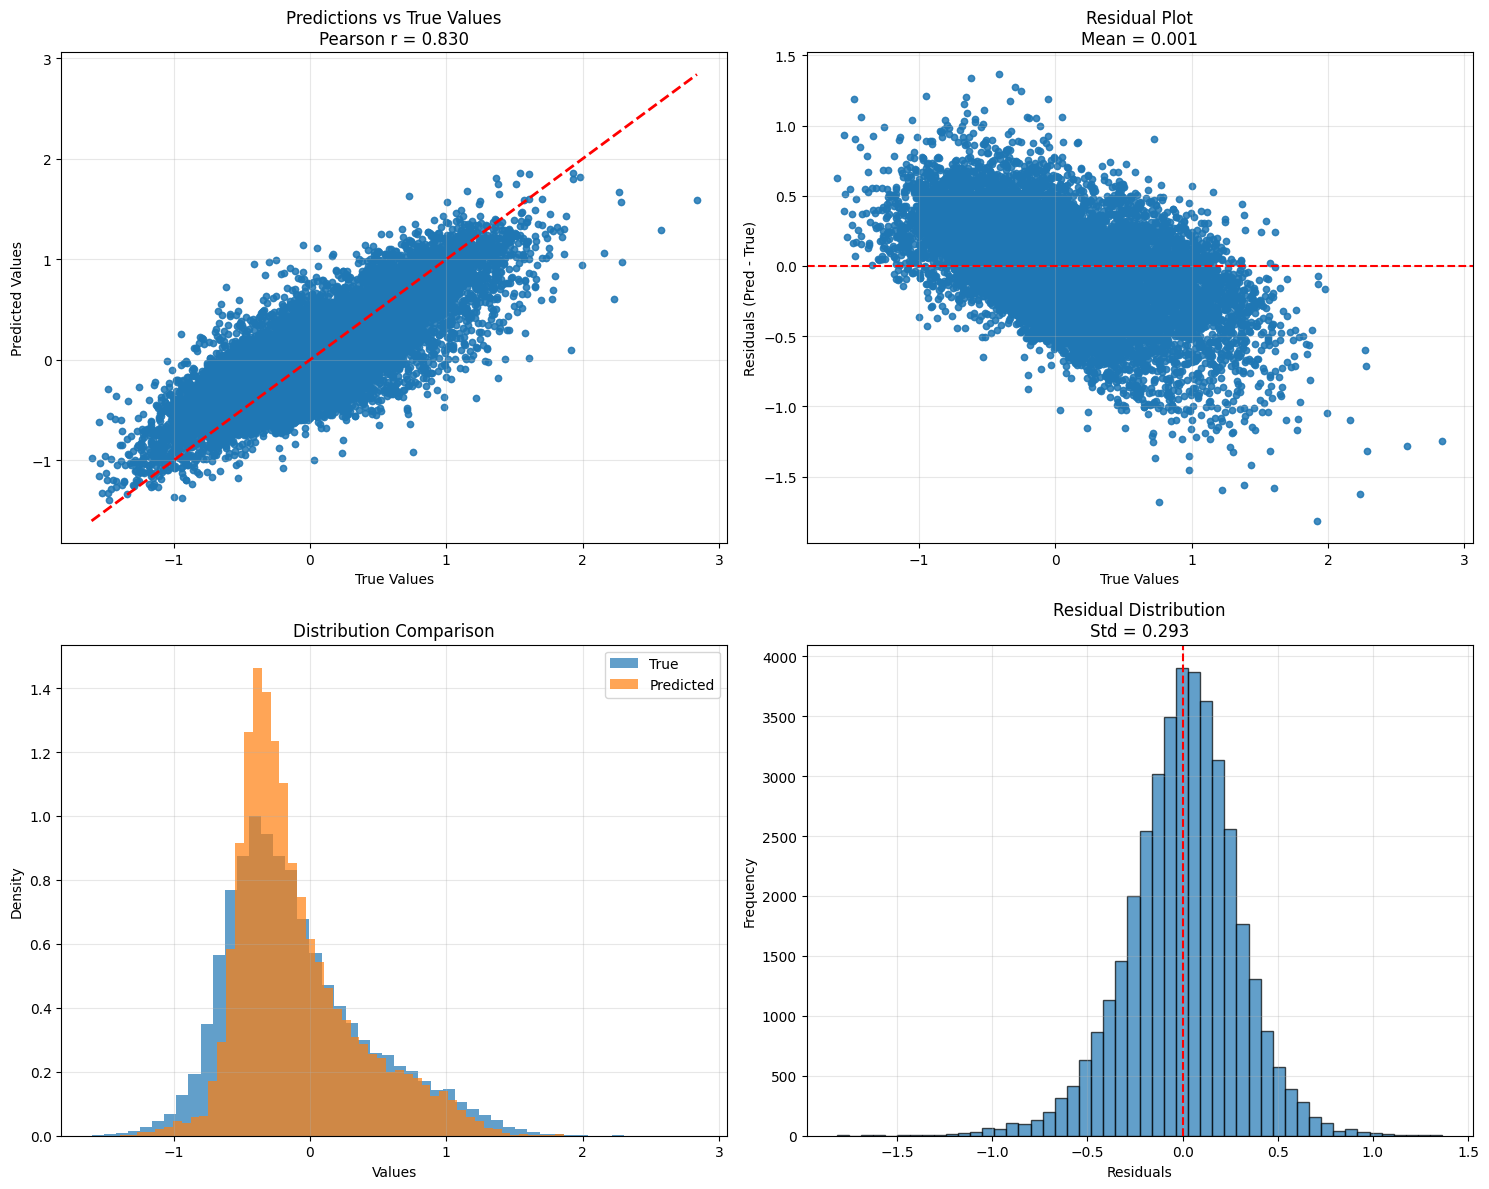

Evaluation report saved to results_rc/1/evaluation_report.txt
Predictions saved to results_rc/1/predictions.csv

Evaluation completed! Results saved to results_rc/1
##### Evaluating checkpoint 2 #####
Loading model from model_weight/2/best_model-epoch=29-val_pearson=0.815.ckpt
Making predictions on test split...
Using test-time augmentation with reverse complement...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:12<00:00,  3.11it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:10<00:00,  3.55it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/2/evaluation_plots.png


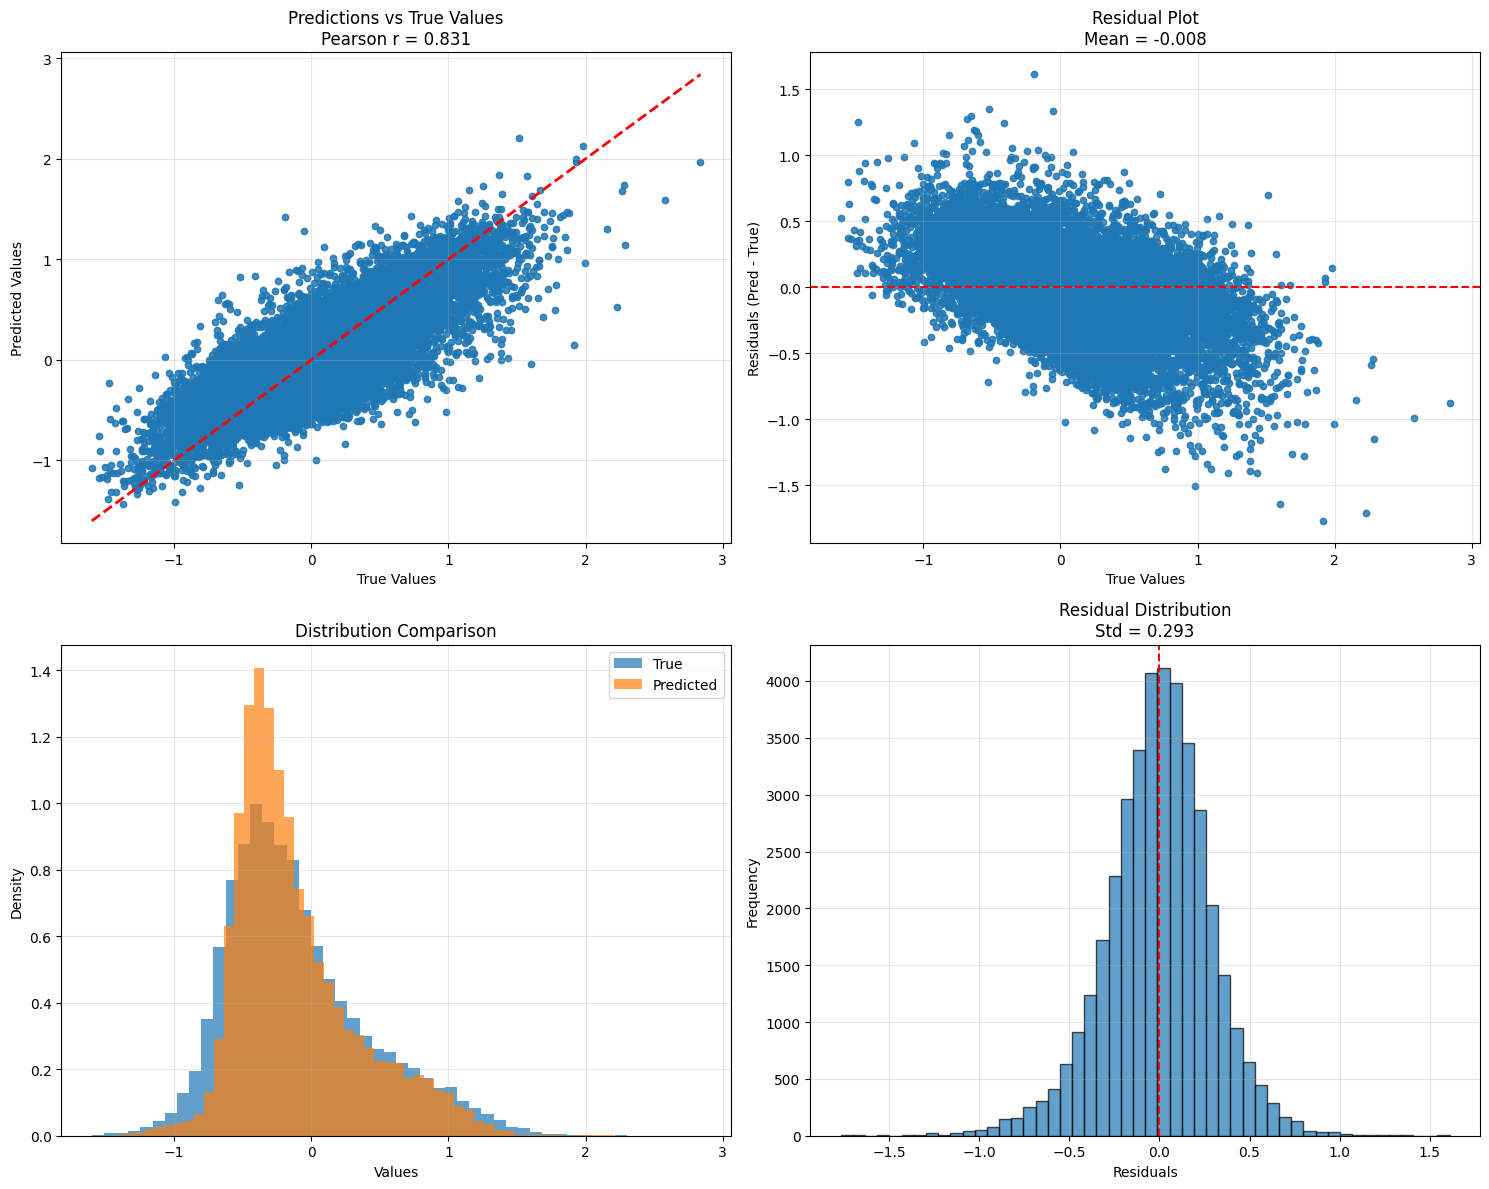

Evaluation report saved to results_rc/2/evaluation_report.txt
Predictions saved to results_rc/2/predictions.csv

Evaluation completed! Results saved to results_rc/2
##### Evaluating checkpoint 3 #####
Loading model from model_weight/3/best_model-epoch=27-val_pearson=0.815.ckpt
Making predictions on test split...
Using test-time augmentation with reverse complement...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:12<00:00,  3.07it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/3/evaluation_plots.png


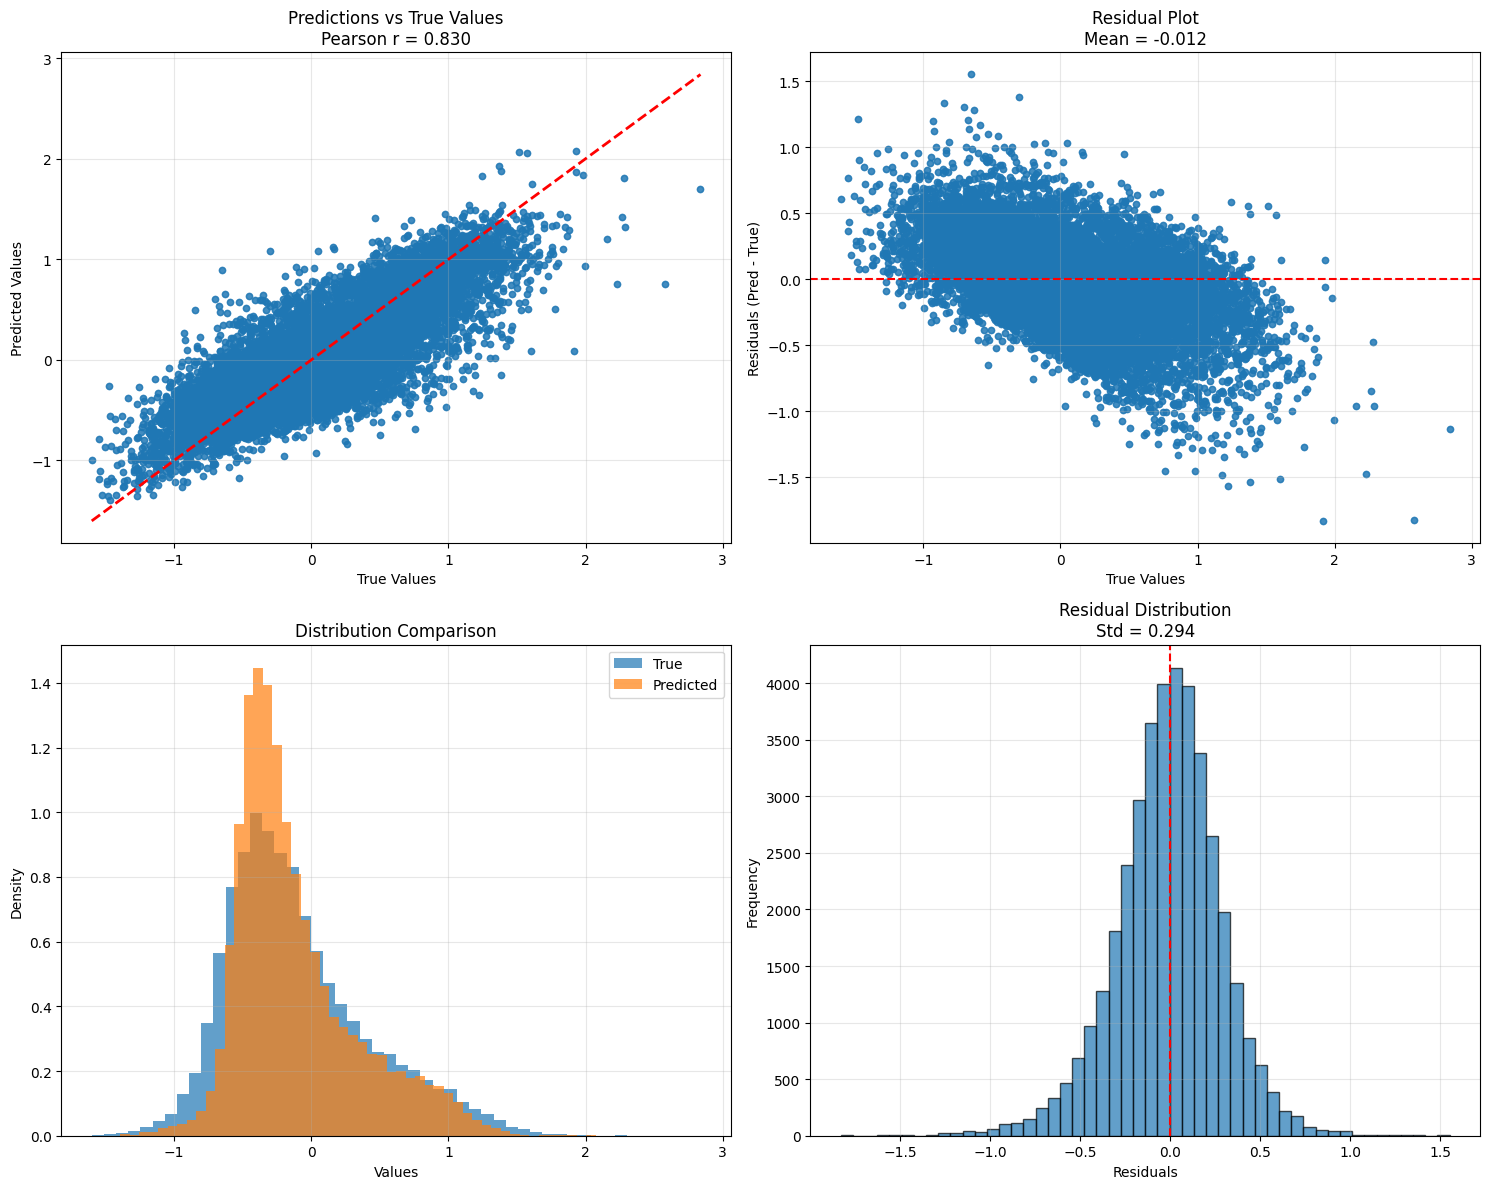

Evaluation report saved to results_rc/3/evaluation_report.txt
Predictions saved to results_rc/3/predictions.csv

Evaluation completed! Results saved to results_rc/3
##### Evaluating checkpoint 4 #####
Loading model from model_weight/4/best_model-epoch=27-val_pearson=0.815.ckpt
Making predictions on test split...
Using test-time augmentation with reverse complement...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:10<00:00,  3.70it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.27it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/4/evaluation_plots.png


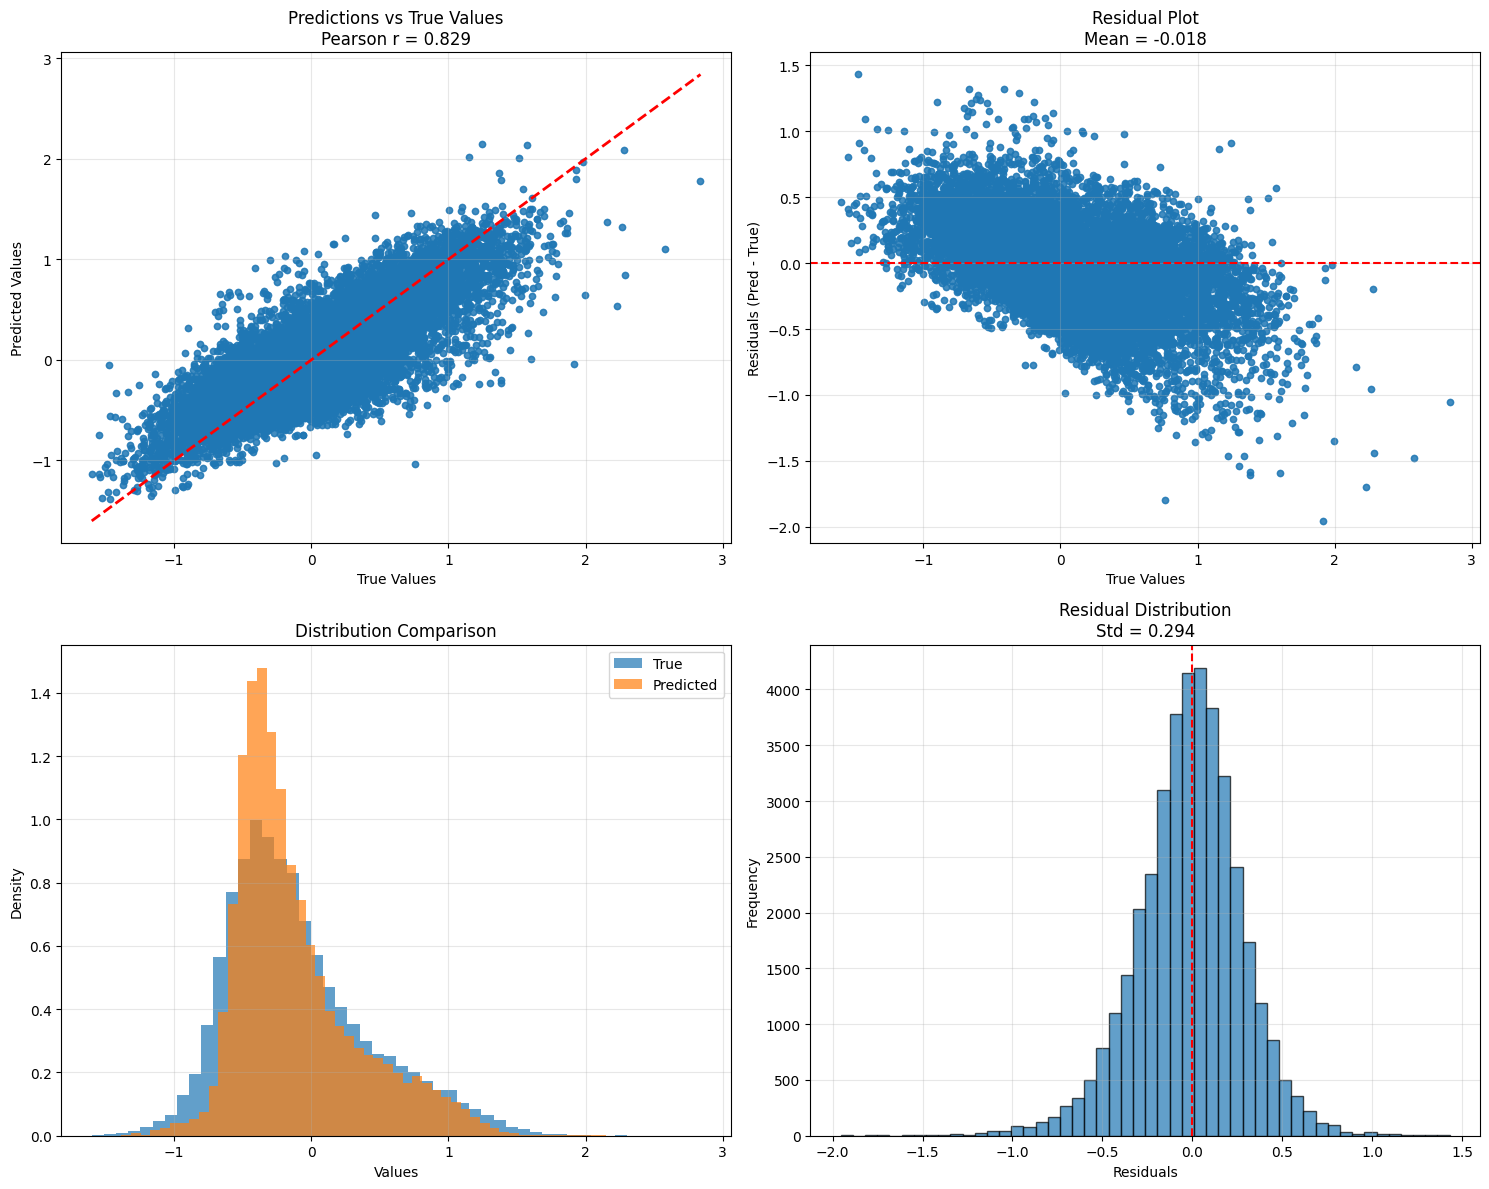

Evaluation report saved to results_rc/4/evaluation_report.txt
Predictions saved to results_rc/4/predictions.csv

Evaluation completed! Results saved to results_rc/4
##### Evaluating checkpoint 5 #####
Loading model from model_weight/5/best_model-epoch=27-val_pearson=0.813.ckpt
Making predictions on test split...
Using test-time augmentation with reverse complement...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.49it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/5/evaluation_plots.png


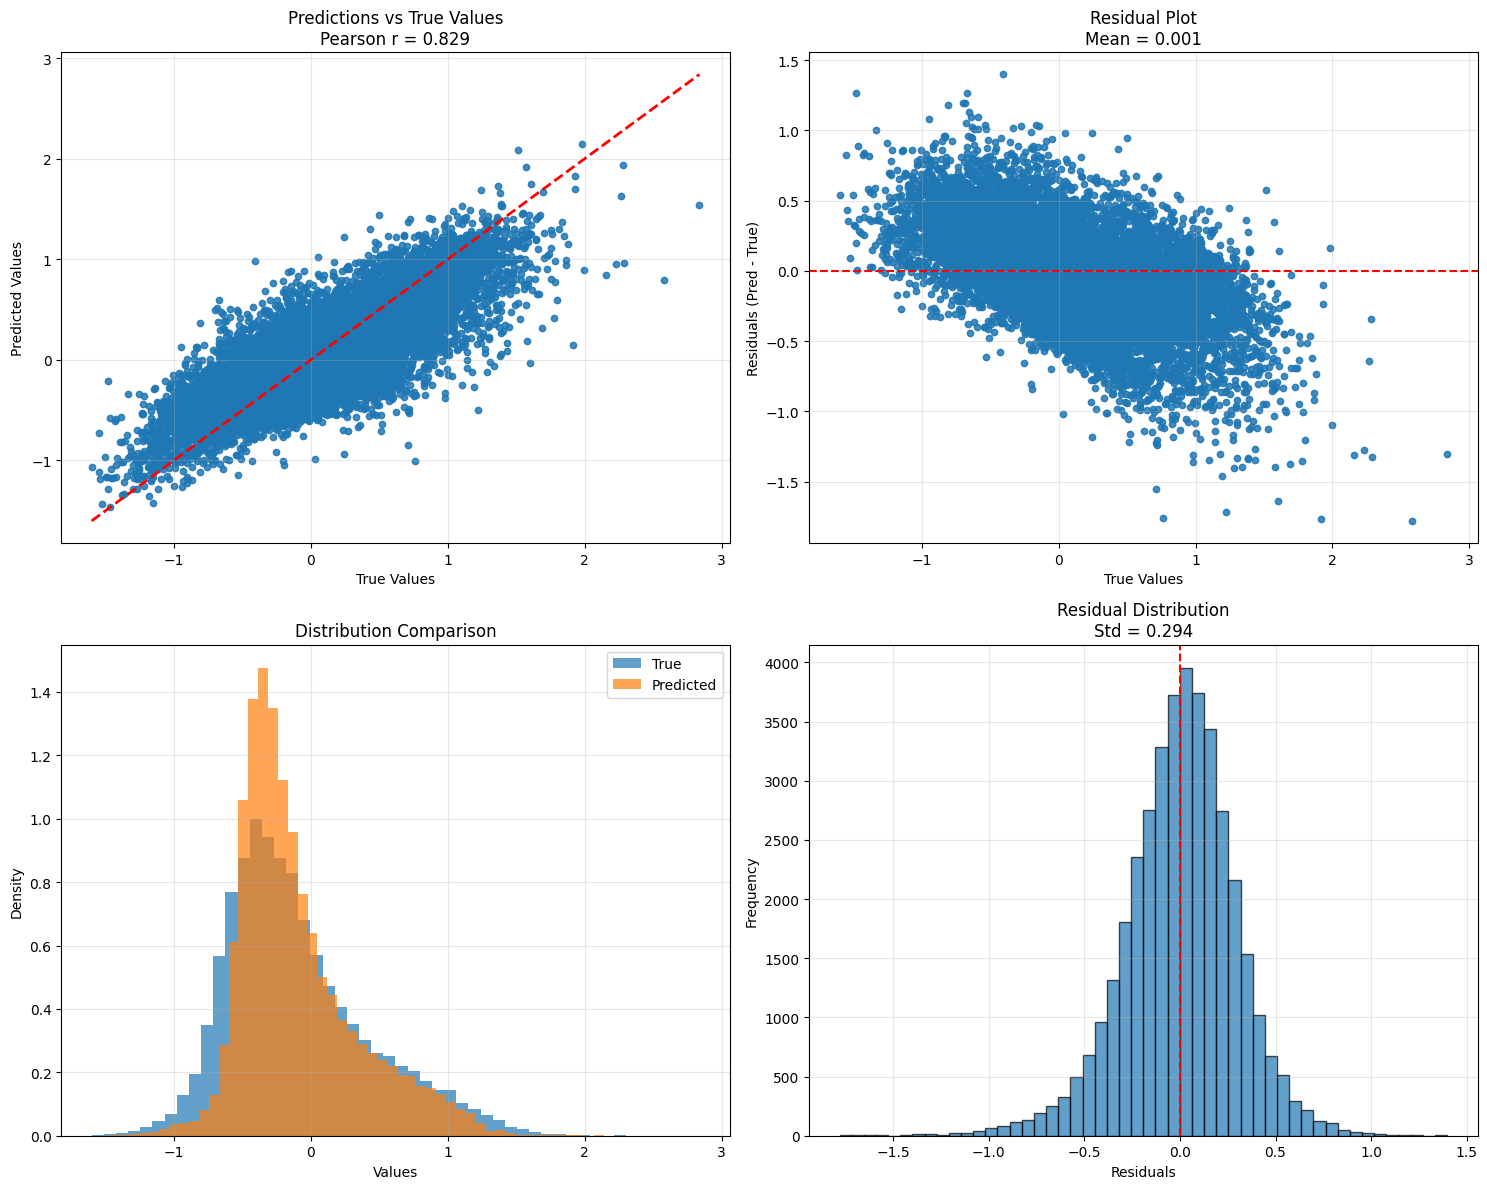

Evaluation report saved to results_rc/5/evaluation_report.txt
Predictions saved to results_rc/5/predictions.csv

Evaluation completed! Results saved to results_rc/5
##### Evaluating checkpoint 6 #####
Loading model from model_weight/6/best_model-epoch=28-val_pearson=0.811.ckpt


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Making predictions on test split...
Using test-time augmentation with reverse complement...
Predicting DataLoader 0: 100%|██████████| 39/39 [00:12<00:00,  3.19it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:12<00:00,  3.24it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/6/evaluation_plots.png


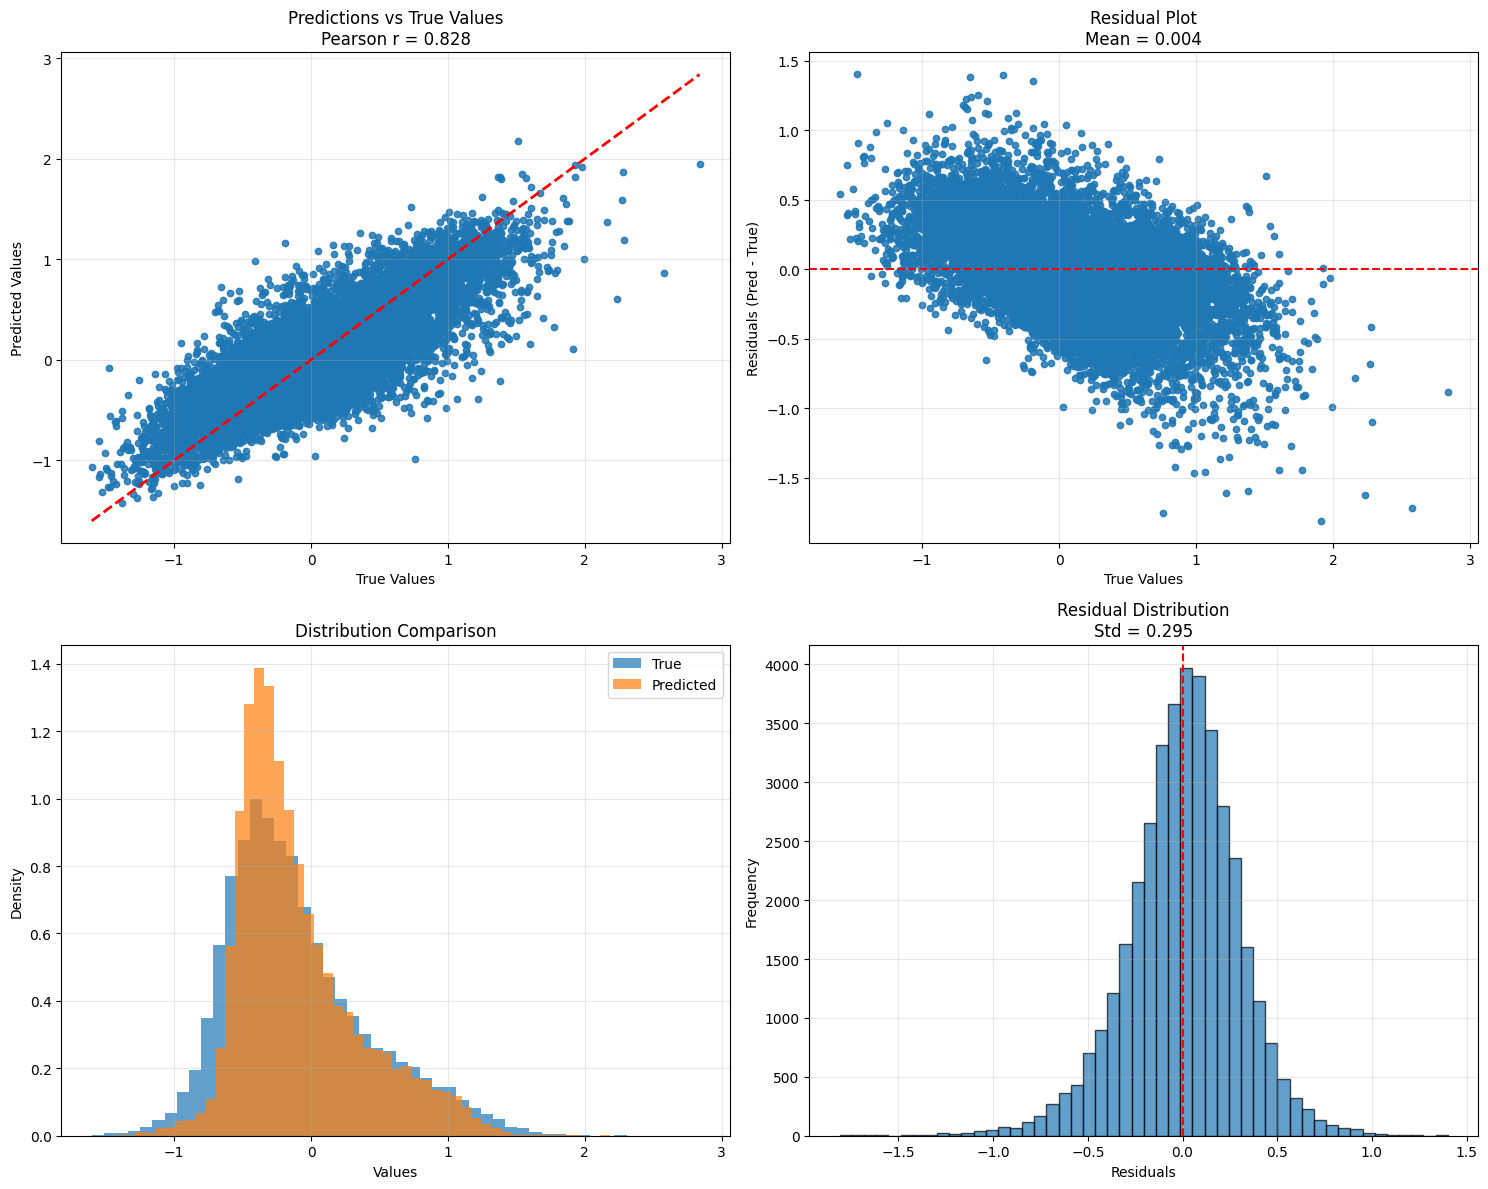

Evaluation report saved to results_rc/6/evaluation_report.txt
Predictions saved to results_rc/6/predictions.csv

Evaluation completed! Results saved to results_rc/6
##### Evaluating checkpoint 7 #####
Loading model from model_weight/7/best_model-epoch=27-val_pearson=0.814.ckpt
Making predictions on test split...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using test-time augmentation with reverse complement...
Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.51it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:13<00:00,  2.94it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/7/evaluation_plots.png


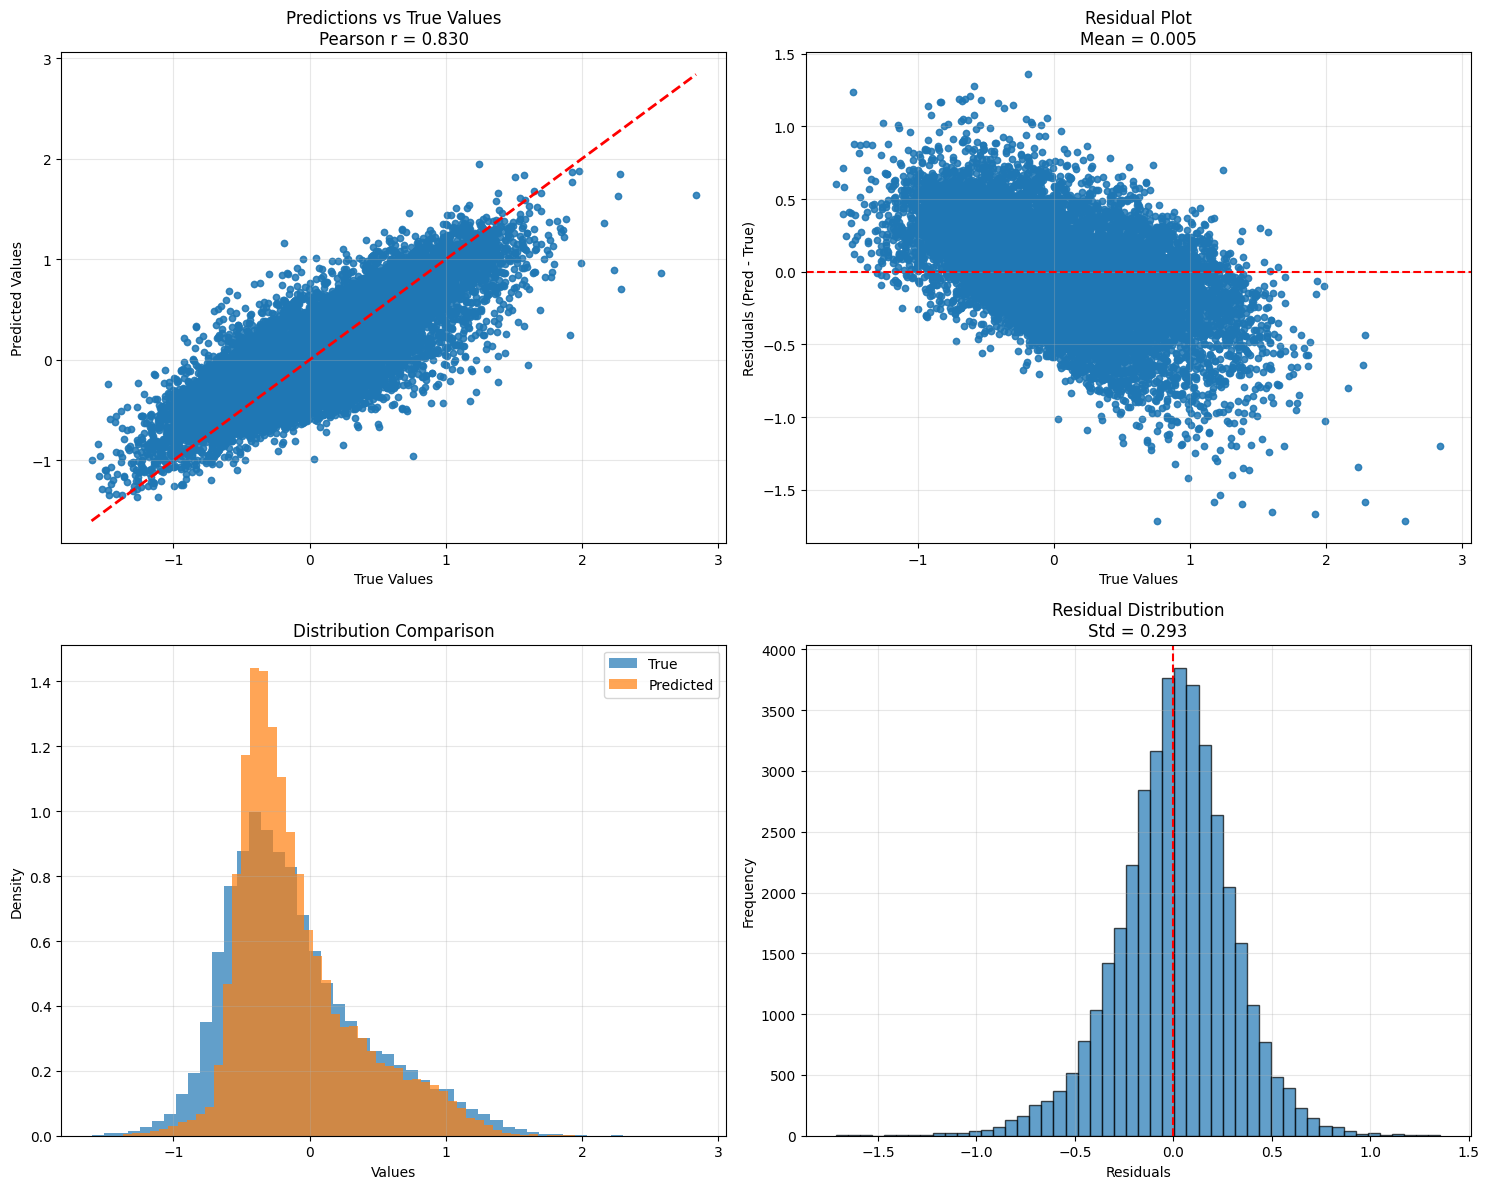

Evaluation report saved to results_rc/7/evaluation_report.txt
Predictions saved to results_rc/7/predictions.csv

Evaluation completed! Results saved to results_rc/7
##### Evaluating checkpoint 8 #####
Loading model from model_weight/8/best_model-epoch=28-val_pearson=0.815.ckpt
Making predictions on test split...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using test-time augmentation with reverse complement...
Predicting DataLoader 0: 100%|██████████| 39/39 [00:14<00:00,  2.78it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:12<00:00,  3.22it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/8/evaluation_plots.png


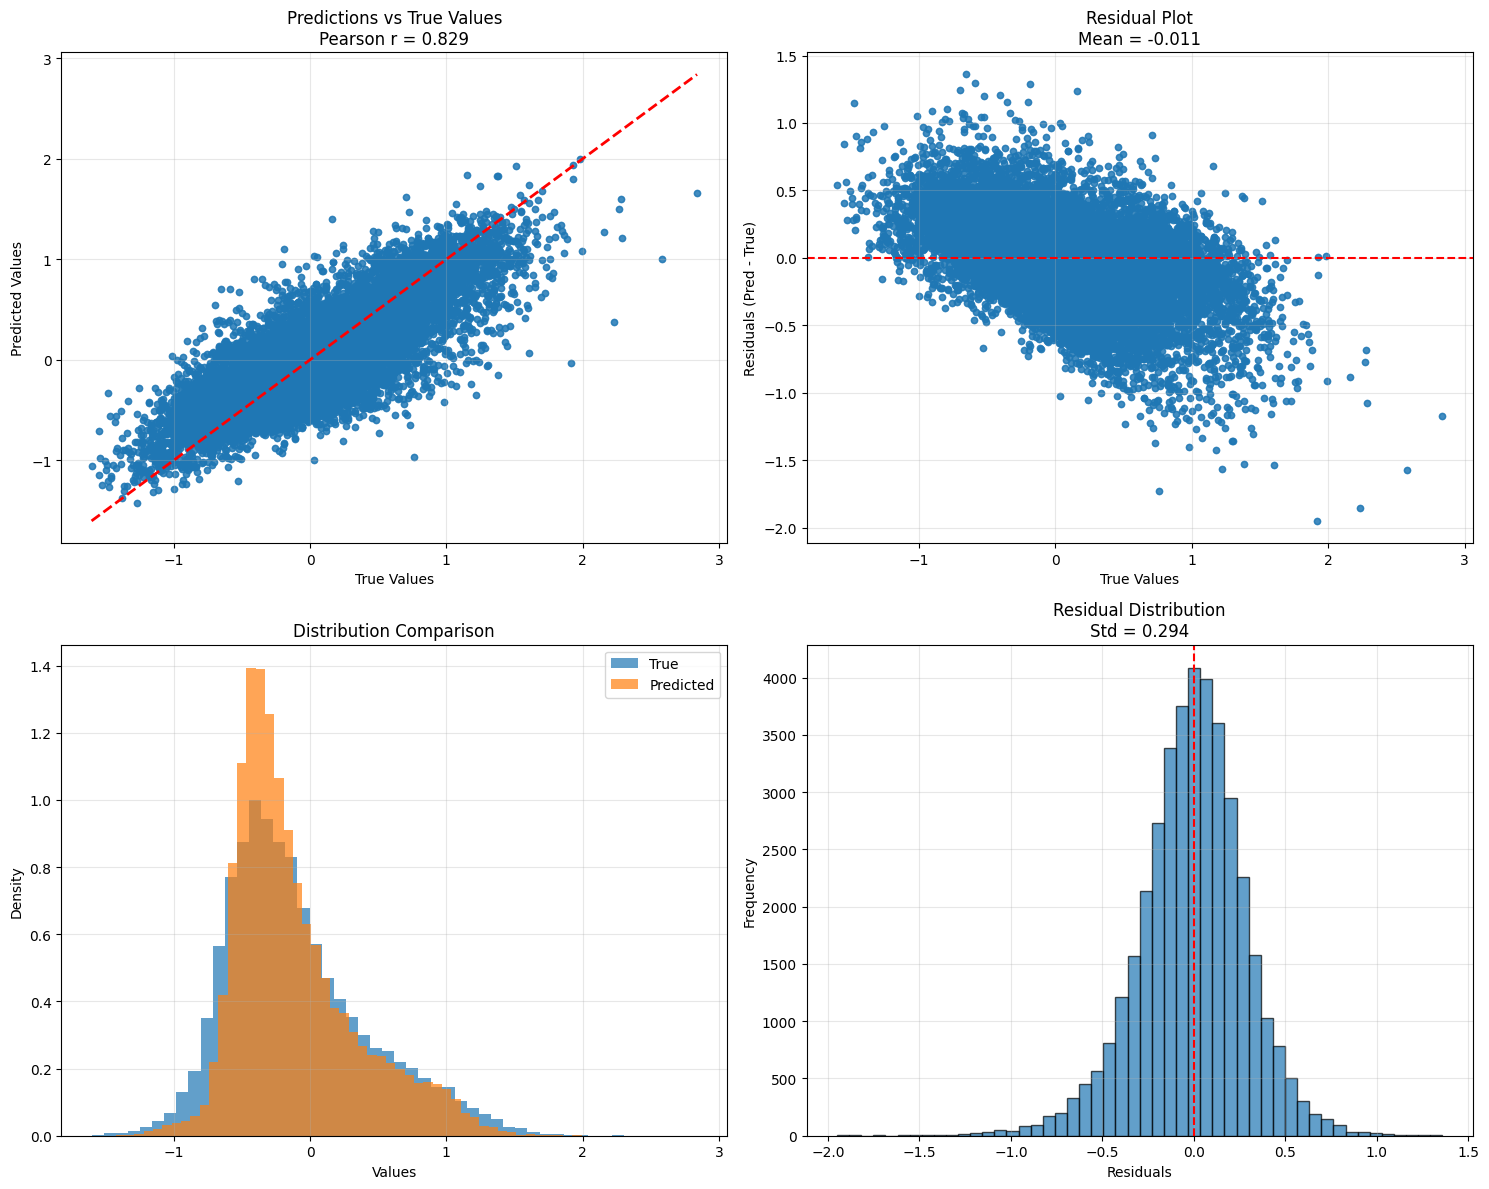

Evaluation report saved to results_rc/8/evaluation_report.txt
Predictions saved to results_rc/8/predictions.csv

Evaluation completed! Results saved to results_rc/8
##### Evaluating checkpoint 9 #####
Loading model from model_weight/9/best_model-epoch=28-val_pearson=0.813.ckpt
Making predictions on test split...


/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/koo/home/nagai/projects/continual_learning/ins ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using test-time augmentation with reverse complement...
Predicting DataLoader 0: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 39/39 [00:13<00:00,  2.89it/s]
Generated predictions for 39340 samples
Calculating evaluation metrics...
Creating evaluation plots...
Evaluation plots saved to results_rc/9/evaluation_plots.png


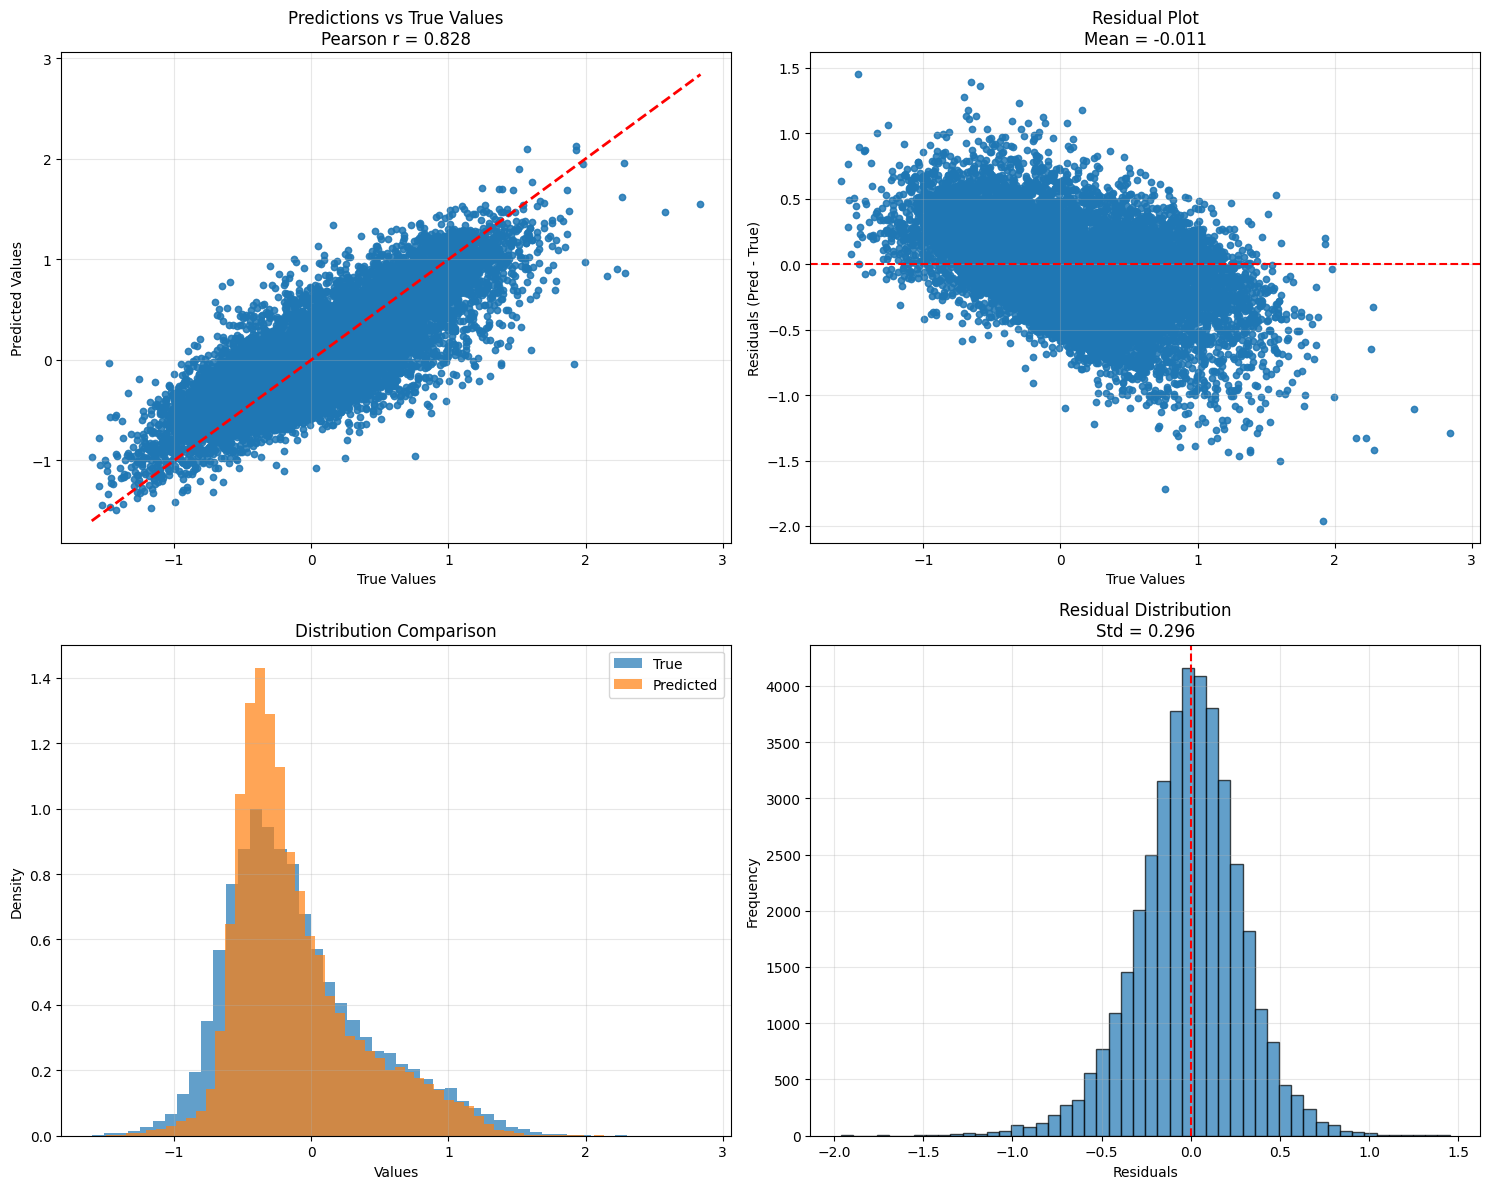

Evaluation report saved to results_rc/9/evaluation_report.txt
Predictions saved to results_rc/9/predictions.csv

Evaluation completed! Results saved to results_rc/9


In [9]:
root_dir = Path('model_weight')
ckpt_paths = sorted(root_dir.glob('*/best_model-epoch=*.ckpt'))
data = "./lenti_MPRA_K562_data.h5"
split = "test"
reverse_complement = True

for i, checkpoint_path in enumerate(ckpt_paths):
    print(f"##### Evaluating checkpoint {i} #####")
    output_dir = Path(f"./results_rc/{i}")
    config_path = root_dir / f"{i}/config.json"
    run(
        checkpoint=checkpoint_path,
        config=config_path,
        data=data,
        split=split,
        batch_size=1024,
        num_workers=4,
        output_dir=output_dir,
        reverse_complement=reverse_complement,
    )

In [23]:
data = "./lenti_MPRA_K562_data.h5"

import h5py
with h5py.File(data, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['onehot_test', 'onehot_train', 'onehot_valid', 'seq_test', 'seq_train', 'seq_valid', 'y_test', 'y_train', 'y_valid']>


## Ensemble

In [21]:
output_dir = Path(f"./results")
df = pd.read_csv(output_dir / "0/predictions.csv", usecols=["targets"])

for i in range(10):
    preds = pd.read_csv(output_dir / f"{i}/predictions.csv", usecols=["predictions"])
    df[f"predictions_{i}"] = preds["predictions"]

df['predictions_ensemble'] = df[[f'predictions_{i}' for i in range(10)]].mean(axis=1)
df.to_csv(output_dir / "ensemble/predictions.csv", index=False)

In [18]:
df

,targets,predictions_0,predictions_1,predictions_2,predictions_3,predictions_4,predictions_5,predictions_6,predictions_7,predictions_8,predictions_9,predictions_ensemble
0,-0.554,-0.370780,-0.426667,-0.379844,-0.508188,-0.426439,-0.335991,-0.537554,-0.448482,-0.367372,-0.481859,-0.428318
1,-0.487,-0.563535,-0.453182,-0.553994,-0.369320,-0.541296,-0.409495,-0.451532,-0.443914,-0.469861,-0.507995,-0.476412
2,-0.449,-0.386140,-0.401035,-0.439184,-0.398329,-0.439532,-0.401135,-0.409487,-0.463593,-0.368015,-0.451767,-0.415822
3,-0.565,-0.466190,-0.417839,-0.415394,-0.386522,-0.479129,-0.411335,-0.385546,-0.402449,-0.418206,-0.466260,-0.424887
4,-0.206,-0.463309,-0.340923,-0.553588,-0.355125,-0.377167,-0.399299,-0.535478,-0.438624,-0.432938,-0.532386,-0.442884
...,...,...,...,...,...,...,...,...,...,...,...,...
39335,0.464,0.750358,0.742231,0.736730,0.575245,0.429588,0.478690,0.439458,0.756317,0.920164,0.151391,0.598017
39336,-0.685,-0.552888,-0.534479,-0.598844,-0.473516,-0.564377,-0.516801,-0.455346,-0.464526,-0.552518,-0.493920,-0.520721
39337,-0.830,-0.522733,-0.538824,-0.542496,-0.490314,-0.649607,-0.596750,-0.510983,-0.546289,-0.507232,-0.426634,-0.533186
39338,-0.068,0.201745,0.203189,0.274900,-0.054917,0.023845,0.202607,0.743418,-0.088059,0.007018,0.551016,0.206476


In [22]:
output_dir = Path(f"./results_rc")
df_rc = pd.read_csv(output_dir / "0/predictions.csv", usecols=["targets"])

for i in range(10):
    preds = pd.read_csv(output_dir / f"{i}/predictions.csv", usecols=["predictions"])
    df_rc[f"predictions_{i}"] = preds["predictions"]

df_rc['predictions_ensemble'] = df_rc[[f'predictions_{i}' for i in range(10)]].mean(axis=1)
df_rc.to_csv(output_dir / "ensemble/predictions.csv", index=False)

In [23]:
df_rc

,targets,predictions_0,predictions_1,predictions_2,predictions_3,predictions_4,predictions_5,predictions_6,predictions_7,predictions_8,predictions_9,predictions_ensemble
0,-0.554,-0.446123,-0.428638,-0.464865,-0.433928,-0.468683,-0.391304,-0.513063,-0.461336,-0.404986,-0.526783,-0.453971
1,-0.487,-0.484154,-0.462605,-0.474284,-0.437237,-0.452359,-0.354766,-0.486416,-0.454093,-0.482457,-0.493707,-0.458208
2,-0.449,-0.435498,-0.432282,-0.430215,-0.389182,-0.464084,-0.414144,-0.429559,-0.471822,-0.420676,-0.478168,-0.436563
3,-0.565,-0.404052,-0.428125,-0.425852,-0.431658,-0.468944,-0.388442,-0.403391,-0.435867,-0.427231,-0.448973,-0.426254
4,-0.206,-0.457565,-0.349395,-0.491822,-0.361795,-0.388445,-0.439840,-0.511948,-0.431647,-0.462233,-0.521814,-0.441651
...,...,...,...,...,...,...,...,...,...,...,...,...
39335,0.464,0.738259,0.607416,0.685599,0.564338,0.574038,0.435975,0.562130,0.733674,0.879391,0.172393,0.595321
39336,-0.685,-0.541304,-0.537492,-0.549475,-0.470111,-0.539472,-0.547049,-0.499028,-0.470882,-0.560177,-0.471774,-0.518676
39337,-0.830,-0.565839,-0.536495,-0.559424,-0.498165,-0.620653,-0.520801,-0.471922,-0.549552,-0.557470,-0.481125,-0.536145
39338,-0.068,0.138818,0.226359,0.371705,-0.030018,0.039507,0.206587,0.710420,0.140386,0.459993,0.257652,0.252141


In [19]:
targets = df['targets'].values

scores = []
for i in range(10):
    predictions = df[f'predictions_{i}'].values
    print(f"Calculating evaluation metrics for model {i}...")
    metrics = calculate_metrics(targets, predictions)
    scores.append(metrics['pearson_correlation'])

predictions = df['predictions_ensemble'].values
print("Calculating evaluation metrics for ensemble model...")
ensemble_metrics = calculate_metrics(targets, predictions)
scores.append(ensemble_metrics['pearson_correlation'])

Calculating evaluation metrics for model 0...
Calculating evaluation metrics for model 1...
Calculating evaluation metrics for model 2...
Calculating evaluation metrics for model 3...
Calculating evaluation metrics for model 4...
Calculating evaluation metrics for model 5...
Calculating evaluation metrics for model 6...
Calculating evaluation metrics for model 7...
Calculating evaluation metrics for model 8...
Calculating evaluation metrics for model 9...
Calculating evaluation metrics for ensemble model...


In [24]:
# targets = df_rc['targets'].values

scores_rc = []
for i in range(10):
    predictions = df_rc[f'predictions_{i}'].values
    print(f"Calculating evaluation metrics for model {i}...")
    metrics = calculate_metrics(targets, predictions)
    scores_rc.append(metrics['pearson_correlation'])

predictions = df_rc['predictions_ensemble'].values
print("Calculating evaluation metrics for ensemble model...")
ensemble_metrics = calculate_metrics(targets, predictions)
scores_rc.append(ensemble_metrics['pearson_correlation'])

Calculating evaluation metrics for model 0...
Calculating evaluation metrics for model 1...
Calculating evaluation metrics for model 2...
Calculating evaluation metrics for model 3...
Calculating evaluation metrics for model 4...
Calculating evaluation metrics for model 5...
Calculating evaluation metrics for model 6...
Calculating evaluation metrics for model 7...
Calculating evaluation metrics for model 8...
Calculating evaluation metrics for model 9...
Calculating evaluation metrics for ensemble model...


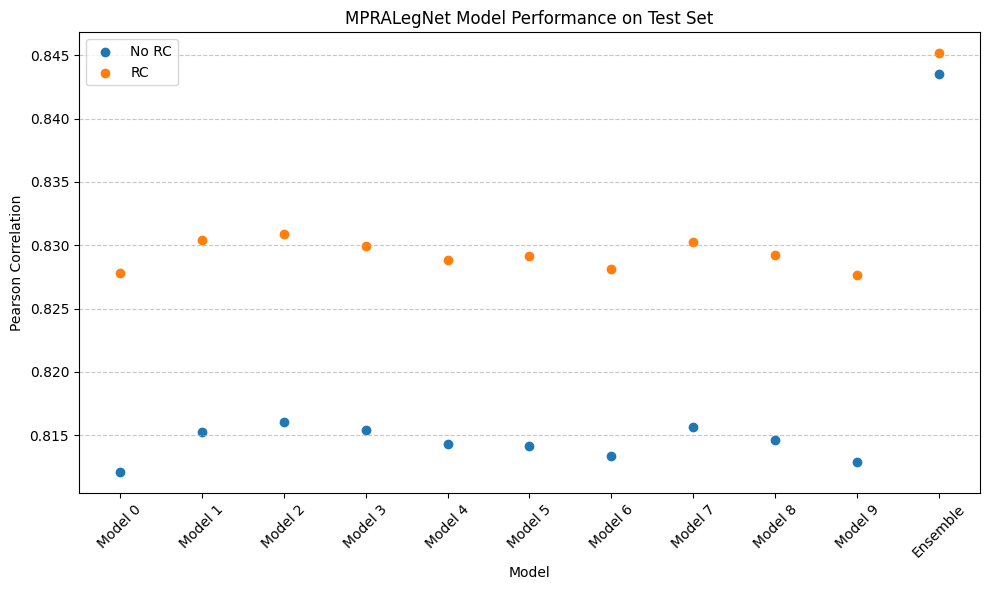

In [29]:
# Plot the scores for each model and the ensemble
plt.figure(figsize=(10, 6))
plt.scatter(range(11), scores, label='No RC')
plt.scatter(range(11), scores_rc, label='RC')
plt.xticks(range(11), [f'Model {i}' for i in range(10)] + ['Ensemble'], rotation=45)
plt.xlabel('Model')
plt.ylabel('Pearson Correlation')
plt.title('MPRALegNet Model Performance on Test Set')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('./model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()